<a href="https://colab.research.google.com/github/fredbeaupre/Einstein-Field-Equations-Solutions/blob/main/EFE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import einsteinpy for tensor helper function

In [1]:
!pip install einsteinpy

In [2]:
import sympy 
from sympy import exp, simplify, tensorcontraction, tensorproduct, sin, cos
from sympy.core.expr import Expr
import numpy as np
import einsteinpy
from einsteinpy.symbolic import MetricTensor, BaseRelativityTensor
from einsteinpy.symbolic.tensor import BaseRelativityTensor, _change_config
from einsteinpy.symbolic.helpers import _change_name, simplify_sympy_array, _flatten_list

%matplotlib inline

from itertools import product
import matplotlib.pyplot as plt
import numba
import numpy as np
from IPython.display import display, Math
from sympy import symbols, latex, lambdify, Matrix
from scipy.integrate import solve_ivp
from sympy.diffgeom import Manifold, Patch, CoordSystem, metric_to_Christoffel_2nd, TensorProduct

In [3]:
def latex_print(something):
  display(Math(latex(something)))

# Christoffel Symbols

In [4]:
class ChristoffelSymbols(BaseRelativityTensor):
  
  def __init__(self,
               arr,
               syms,
               config="ull",
               parent_metric=None,
               name="ChristoffelSymbols"):
    
    super(ChristoffelSymbols, self).__init__(
        arr=arr, syms=syms, config=config, parent_metric=parent_metric, name=name
    )
    self._order = 3
    if not len(self.config) == self._order:
      raise ValueError("Error: wrong config")

  @classmethod
  def compute_christoffel(cls, metric):
    dims = metric.dims
    temp_list = np.zeros((dims, dims, dims), dtype=int).tolist()
    mat, syms = metric.lower_config().tensor(), metric.symbols()
    inv_mat = sympy.Matrix(mat.tolist()).inv()
    for t in range(dims ** 3):
      k = t % dims
      j = (int(t / dims)) % (dims)
      i = (int(t / (dims ** 2))) % (dims)
      if k <= j:
          temp = 0
          for n in range(dims):
              temp += (inv_mat[i, n] / 2) * (
                  sympy.diff(mat[n, j], syms[k])
                  + sympy.diff(mat[n, k], syms[j])
                  - sympy.diff(mat[j, k], syms[n])
              )
          temp_list[i][j][k] = temp_list[i][k][j] = temp
    return cls(temp_list, syms, config="ull", parent_metric=metric)

  


# Riemann Tensor

In [5]:
class RiemannTensor(BaseRelativityTensor):

    def __init__(
        self,
        arr,
        syms,
        config="ulll",
        parent_metric=None,
        name="RiemannTensor",
    ):
       
        super(RiemannTensor, self).__init__(
            arr=arr, syms=syms, config=config, parent_metric=parent_metric, name=name
        )
        self._order = 4
        if not len(config) == self._order:
            raise ValueError("config should be of length {}".format(self._order))

    @classmethod
    def compute_riemann(cls, chris, parent_metric=None):
        if not chris.config == "ull":
            chris = chris.change_config(newconfig="ull", metric=parent_metric)
        arr, syms = chris.tensor(), chris.symbols()
        dims = len(syms)
        riemann = (np.zeros(shape=(dims, dims, dims, dims), dtype=int)).tolist()
        for i in range(dims ** 4):
            n = i % dims
            r = (int(i / dims)) % (dims)
            s = (int(i / (dims ** 2))) % (dims)
            t = (int(i / (dims ** 3))) % (dims)
            temp = sympy.diff(arr[t, s, n], syms[r]) - sympy.diff(arr[t, s, r], syms[n])
            for p in range(dims):
                temp += arr[p, s, n] * arr[t, p, r] - arr[p, s, r] * arr[t, p, n]
            riemann[t][s][r][n] = sympy.simplify(temp)
        if parent_metric is None:
            parent_metric = chris.parent_metric
        return cls(riemann, syms, config="ulll", parent_metric=parent_metric)
      
    def change_config(self, newconfig="llll", metric=None):
      if metric is None:
          metric = self._parent_metric
      if metric is None:
          raise Exception("No Parent Metric Found")
      new_tensor = _change_config(self, metric, newconfig)
      new_obj = RiemannCurvatureTensor(
          new_tensor,
          self.syms,
          config=newconfig,
          parent_metric=metric,
          name=_change_name(self.name, context="__" + newconfig),
      )
      return new_obj


# Ricci Tensor

In [6]:
class RicciTensor(BaseRelativityTensor):

    def __init__(self, arr, syms, config="ll", parent_metric=None, name="RicciTensor"):
        super(RicciTensor, self).__init__(
            arr=arr, syms=syms, config=config, parent_metric=parent_metric, name=name
        )
        self._order = 2
        if not len(config) == self._order:
            raise ValueError("config should be of length {}".format(self._order))

    @classmethod
    def compute_ricci_tensor(cls, riemann, parent_metric=None):
        if not riemann.config == "ulll":
            riemann = riemann.change_config(newconfig="ulll", metric=parent_metric)
        if parent_metric is None:
            parent_metric = riemann.parent_metric
        return cls(
            simplify_sympy_array(sympy.tensorcontraction(riemann.tensor(), (0, 2))),
            riemann.syms,
            config="ll",
            parent_metric=parent_metric,
        )


    def change_config(self, newconfig="ul", metric=None):
        if metric is None:
            metric = self._parent_metric
        if metric is None:
            raise Exception("No Parent Metric Found")
        new_tensor = _change_config(self, metric, newconfig)
        new_obj = RicciTensor(
            new_tensor,
            self.syms,
            config=newconfig,
            parent_metric=metric,
            name=_change_name(self.name, context="__" + newconfig),
        )
        return new_obj

# Ricci Scalar

In [7]:
class RicciScalar(BaseRelativityTensor):

    def __init__(self, arr, syms, parent_metric=None):
        super(RicciScalar, self).__init__(
            arr=arr,
            syms=syms,
            config="",
            parent_metric=parent_metric,
            name="RicciScalar",
        )
        self._order = 0

    @property
    def expr(self):
        val = sum(self.arr) 
        return val

    @classmethod
    def compute_ricci_scalar(cls, riccitensor, parent_metric=None):
        if not riccitensor.config == "ul":
            riccitensor = riccitensor.change_config(
                newconfig="ul", metric=parent_metric
            )
        if parent_metric is None:
            parent_metric = riccitensor.parent_metric
        ricci_scalar = tensorcontraction(riccitensor.tensor(), (0, 1))
        return cls(
            simplify_sympy_array(ricci_scalar),
            riccitensor.syms,
            parent_metric=parent_metric,
        )

   

# Einstein Tensor

In [8]:
class EinsteinTensor(BaseRelativityTensor):

    def __init__(
        self, arr, syms, config="ll", parent_metric=None, name="EinsteinTensor"
    ):
        super(EinsteinTensor, self).__init__(
            arr=arr, syms=syms, config=config, parent_metric=parent_metric, name=name
        )
        self._order = 2
        if not len(config) == self._order:
            raise ValueError("Error: Wrong config")

    @classmethod
    def compute_einstein_tensor(cls, ricci_t, ricci_s, metric):
        einstein_tensor = (
            ricci_t.tensor() - (1 / 2) * metric.lower_config().tensor() * ricci_s.expr
        )
        return cls(
            einstein_tensor,
            metric.syms,
            config="ll",
            parent_metric=ricci_t.parent_metric,
        )

    def change_config(self, newconfig="ul", metric=None):
        if metric is None:
            metric = self._parent_metric
        if metric is None:
            raise Exception("Parent Metric not found, can't do configuration change")
        new_tensor = _change_config(self, metric, newconfig)
        new_obj = EinsteinTensor(
            new_tensor,
            self.syms,
            config=newconfig,
            parent_metric=metric,
            name=_change_name(self.name, context="__" + newconfig),
        )
        return new_obj

# Schwarzchild Metric

In [9]:
metric_syms = sympy.symbols('t r theta phi')
R_sym = sympy.symbols('R')
metric = [[ 0 for i in range(4)] for i in range(4)]
metric[0][0] = -(1 - (R_sym/metric_syms[1]))
metric[1][1] = (1 - (R_sym/metric_syms[1]))**(-1)
metric[2][2] = metric_syms[1]**2
metric[3][3] = (metric_syms[1]**2) * (sin(metric_syms[2]))**2
m_obj = MetricTensor(metric, metric_syms)
m_obj.tensor()

[[R/r - 1, 0, 0, 0], [0, 1/(-R/r + 1), 0, 0], [0, 0, r**2, 0], [0, 0, 0, r**2*sin(theta)**2]]

## Christoffel Symbols for the Schwarzchild Metric

In [10]:
ch = ChristoffelSymbols.compute_christoffel(m_obj)
ch.tensor()

[[[0, -R/(2*r**2*(R/r - 1)), 0, 0], [-R/(2*r**2*(R/r - 1)), 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]], [[R*(-R/(2*r) + 1/2)/r**2, 0, 0, 0], [0, -R*(-R/(2*r) + 1/2)/(r**2*(-R/r + 1)**2), 0, 0], [0, 0, -2*r*(-R/(2*r) + 1/2), 0], [0, 0, 0, -2*r*(-R/(2*r) + 1/2)*sin(theta)**2]], [[0, 0, 0, 0], [0, 0, 1/r, 0], [0, 1/r, 0, 0], [0, 0, 0, -sin(theta)*cos(theta)]], [[0, 0, 0, 0], [0, 0, 0, 1/r], [0, 0, 0, cos(theta)/sin(theta)], [0, 1/r, cos(theta)/sin(theta), 0]]]

In [11]:
for i, j, k in product(range(4), range(4), range(4)):
    if ch[i, j, k] != 0:
        display(Math(f'\Gamma^{i}_{{{j},{k}}} = ' + latex(ch[i, j, k])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Riemann Curvature Tensor Results for the Schwarzchild Metric

In [12]:
riemann = RiemannTensor.compute_riemann(ch)
riemann.tensor()

[[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]], [[0, R/(r**2*(-R + r)), 0, 0], [R/(r**2*(R - r)), 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]], [[0, 0, -R/(2*r), 0], [0, 0, 0, 0], [R/(2*r), 0, 0, 0], [0, 0, 0, 0]], [[0, 0, 0, -R*sin(theta)**2/(2*r)], [0, 0, 0, 0], [0, 0, 0, 0], [R*sin(theta)**2/(2*r), 0, 0, 0]]], [[[0, R*(-R + r)/r**4, 0, 0], [R*(R - r)/r**4, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]], [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]], [[0, 0, 0, 0], [0, 0, -R/(2*r), 0], [0, R/(2*r), 0, 0], [0, 0, 0, 0]], [[0, 0, 0, 0], [0, 0, 0, -R*sin(theta)**2/(2*r)], [0, 0, 0, 0], [0, R*sin(theta)**2/(2*r), 0, 0]]], [[[0, 0, R*(R - r)/(2*r**4), 0], [0, 0, 0, 0], [R*(-R + r)/(2*r**4), 0, 0, 0], [0, 0, 0, 0]], [[0, 0, 0, 0], [0, 0, R/(2*r**2*(-R + r)), 0], [0, R/(2*r**2*(R - r)), 0, 0], [0, 0, 0, 0]], [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]], [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, R*sin(theta)**2/r], [0, 0, -R*sin(theta)**2/r, 0]]], [[[0, 0, 0, R*(R - r)/(2*r**

In [13]:
for i, j, k, l in product(range(4), range(4), range(4), range(4)):
    if riemann[i, j, k, l] != 0:
        display(Math(f'\R^{i}_{{{j},{k}, {l}}} = ' + latex(riemann[i, j, k, l])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Ricci Tensor for the Schwarzchild Metric

In [14]:
ricci = RicciTensor.compute_ricci_tensor(riemann)
print(f'R_uv = \n')
ricci.tensor()

R_uv = 



[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]

## Ricci Scalar for Schwarzchild metric

In [15]:
ricci_scalar = RicciScalar.compute_ricci_scalar(ricci)
ricci_scalar.simplify()
print(f'R = {ricci_scalar.expr}')

R = 0


## Einstein Tensor for the Schwarzschild Metric

In [16]:
G = EinsteinTensor.compute_einstein_tensor(ricci, ricci_scalar, m_obj)
G.tensor()

[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]

# De Sitter Space

So we see that the Schwarzschild metric is a solution of the source free Einstein equations

## De Sitter Space Metric

In [17]:
syms = sympy.symbols('t x y z')
other_sym = sympy.symbols('H')
sitter_metric = [[ 0 for i in range(4)] for i in range(4)]
sitter_metric[0][0] = -1
sitter_metric[1][1] = exp(2*syms[0]*other_sym)
sitter_metric[2][2] = exp(2*syms[0]*other_sym)
sitter_metric[3][3] = exp(2*syms[0]*other_sym)
sitter_m_obj = MetricTensor(sitter_metric, syms)
sitter_m_obj.tensor()

[[-1, 0, 0, 0], [0, exp(2*H*t), 0, 0], [0, 0, exp(2*H*t), 0], [0, 0, 0, exp(2*H*t)]]

## Christoffel Symbols for de Sitter Space

In [18]:
sitter_ch = ChristoffelSymbols.compute_christoffel(sitter_m_obj)
sitter_ch.tensor()

[[[0, 0, 0, 0], [0, H*exp(2*H*t), 0, 0], [0, 0, H*exp(2*H*t), 0], [0, 0, 0, H*exp(2*H*t)]], [[0, H, 0, 0], [H, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]], [[0, 0, H, 0], [0, 0, 0, 0], [H, 0, 0, 0], [0, 0, 0, 0]], [[0, 0, 0, H], [0, 0, 0, 0], [0, 0, 0, 0], [H, 0, 0, 0]]]

In [19]:
for i, j, k in product(range(4), range(4), range(4)):
    if sitter_ch[i, j, k] != 0:
        display(Math(f'\Gamma^{i}_{{{j},{k}}} = ' + latex(sitter_ch[i, j, k])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Riemann Tensor for de Sitter Space

In [20]:
sitter_riemann = RiemannTensor.compute_riemann(sitter_ch)
sitter_riemann.tensor()

[[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]], [[0, H**2*exp(2*H*t), 0, 0], [-H**2*exp(2*H*t), 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]], [[0, 0, H**2*exp(2*H*t), 0], [0, 0, 0, 0], [-H**2*exp(2*H*t), 0, 0, 0], [0, 0, 0, 0]], [[0, 0, 0, H**2*exp(2*H*t)], [0, 0, 0, 0], [0, 0, 0, 0], [-H**2*exp(2*H*t), 0, 0, 0]]], [[[0, H**2, 0, 0], [-H**2, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]], [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]], [[0, 0, 0, 0], [0, 0, H**2*exp(2*H*t), 0], [0, -H**2*exp(2*H*t), 0, 0], [0, 0, 0, 0]], [[0, 0, 0, 0], [0, 0, 0, H**2*exp(2*H*t)], [0, 0, 0, 0], [0, -H**2*exp(2*H*t), 0, 0]]], [[[0, 0, H**2, 0], [0, 0, 0, 0], [-H**2, 0, 0, 0], [0, 0, 0, 0]], [[0, 0, 0, 0], [0, 0, -H**2*exp(2*H*t), 0], [0, H**2*exp(2*H*t), 0, 0], [0, 0, 0, 0]], [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]], [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, H**2*exp(2*H*t)], [0, 0, -H**2*exp(2*H*t), 0]]], [[[0, 0, 0, H**2], [0, 0, 0, 0], [0, 0, 0, 0], [-H**2, 0, 0, 0]], [[0, 0, 0, 0],

In [21]:
for i, j, k, l in product(range(4), range(4), range(4), range(4)):
    if sitter_riemann[i, j, k, l] != 0:
        display(Math(f'\R^{i}_{{{j},{k}, {l}}} = ' + latex(sitter_riemann[i, j, k, l])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Ricci Tensor for de Sitter Space

In [22]:
sitter_ricci_tensor = RicciTensor.compute_ricci_tensor(sitter_riemann)
sitter_ricci_tensor.tensor()

[[-3*H**2, 0, 0, 0], [0, 3*H**2*exp(2*H*t), 0, 0], [0, 0, 3*H**2*exp(2*H*t), 0], [0, 0, 0, 3*H**2*exp(2*H*t)]]

In [51]:
for i, j in product(range(4), range(4)):
    if kerr_ch[i, j] != 0:
        display(Math(f'R^_{{{i},{j}}} = ' + latex(sitter_ricci_tensor[i, j])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Ricci Scalar for de Sitter Space

In [23]:
sitter_ricci_scalar = RicciScalar.compute_ricci_scalar(sitter_ricci_tensor)
sitter_ricci_scalar.simplify()
display(Math(f'R  =' +  latex(sitter_ricci_scalar.expr)))

<IPython.core.display.Math object>

## Einstein Tensor for de Sitter Space

In [24]:
G = EinsteinTensor.compute_einstein_tensor(sitter_ricci_tensor, sitter_ricci_scalar, sitter_m_obj)
G.tensor()

[[3.0*H**2, 0, 0, 0], [0, -3.0*H**2*exp(2*H*t), 0, 0], [0, 0, -3.0*H**2*exp(2*H*t), 0], [0, 0, 0, -3.0*H**2*exp(2*H*t)]]

And we see that de Sitter Space is a solution to Einstein's equations with a cosmological constant source, where $\Lambda = 3H^2$

# Kerr Space

In [25]:
from einsteinpy.metric.kerr import Kerr

## Metric for Kerr Space

In [26]:
metric_syms = sympy.symbols('t r theta phi')
R_sym = sympy.symbols('R')
a_sym = sympy.symbols('a')
delta = (metric_syms[1]**2) - (R_sym*metric_syms[1]) + (a_sym**2)
rho2 = (metric_syms[1])**2 + (a_sym**2 * cos(metric_syms[2])**2)
metric = [[ 0 for i in range(4)] for i in range(4)]
metric[0][0] = - (1 - ( R_sym*metric_syms[1]/rho2) )
metric[1][1] = rho2/delta
metric[2][2] = rho2
metric[3][3] = (sin(metric_syms[2])**2 / rho2) * ( 
    (metric_syms[1]**2 + a_sym**2)**2 - a_sym**2*delta*sin(metric_syms[2])**2  )
metric[0][3] = -( (R_sym*a_sym*metric_syms[1]*sin(metric_syms[2])**2) / rho2 )
metric[3][0] = -( (R_sym*a_sym*metric_syms[1]*sin(metric_syms[2])**2) / rho2 )
kerr_metric = MetricTensor(metric, metric_syms)
kerr_metric.tensor()

[[R*r/(a**2*cos(theta)**2 + r**2) - 1, 0, 0, -R*a*r*sin(theta)**2/(a**2*cos(theta)**2 + r**2)], [0, (a**2*cos(theta)**2 + r**2)/(-R*r + a**2 + r**2), 0, 0], [0, 0, a**2*cos(theta)**2 + r**2, 0], [-R*a*r*sin(theta)**2/(a**2*cos(theta)**2 + r**2), 0, 0, (-a**2*(-R*r + a**2 + r**2)*sin(theta)**2 + (a**2 + r**2)**2)*sin(theta)**2/(a**2*cos(theta)**2 + r**2)]]

## Christoffel Symbols for Kerr Metric

In [27]:
kerr_ch = ChristoffelSymbols.compute_christoffel(kerr_metric)
kerr_ch.tensor()

[[[0, (-2*R*r**2/(a**2*cos(theta)**2 + r**2)**2 + R/(a**2*cos(theta)**2 + r**2))*(-R*a**4*r*sin(theta)**2*cos(theta)**2 - R*a**2*r**3*sin(theta)**2 + a**6*sin(theta)**2*cos(theta)**2 - a**6*cos(theta)**2 + a**4*r**2*sin(theta)**2*cos(theta)**2 + a**4*r**2*sin(theta)**2 - 2*a**4*r**2*cos(theta)**2 - a**4*r**2 + a**2*r**4*sin(theta)**2 - a**2*r**4*cos(theta)**2 - 2*a**2*r**4 - r**6)/(2*(R*a**4*r*sin(theta)**2*cos(theta)**2 + R*a**4*r*sin(theta)**2 - R*a**4*r + 2*R*a**2*r**3*sin(theta)**2 - 2*R*a**2*r**3 - R*r**5 - a**6*sin(theta)**2*cos(theta)**2 + a**6*cos(theta)**2 - a**4*r**2*sin(theta)**2*cos(theta)**2 - a**4*r**2*sin(theta)**2 + 2*a**4*r**2*cos(theta)**2 + a**4*r**2 - a**2*r**4*sin(theta)**2 + a**2*r**4*cos(theta)**2 + 2*a**2*r**4 + r**6)) + (-R*a**3*r*cos(theta)**2 - R*a*r**3)*(2*R*a*r**2*sin(theta)**2/(a**2*cos(theta)**2 + r**2)**2 - R*a*sin(theta)**2/(a**2*cos(theta)**2 + r**2))/(2*(R*a**4*r*sin(theta)**2*cos(theta)**2 + R*a**4*r*sin(theta)**2 - R*a**4*r + 2*R*a**2*r**3*sin(theta

In [28]:
for i, j, k in product(range(4), range(4), range(4)):
    if kerr_ch[i, j, k] != 0:
        display(Math(f'\Gamma^{i}_{{{j},{k}}} = ' + latex(kerr_ch[i, j, k])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Riemann Tensor for Kerr Metric

In [30]:
kerr_riemann = RiemannTensor.compute_riemann(kerr_ch)
kerr_riemann

KeyboardInterrupt: ignored

The code above had been running for 7 hours before i decided to interrupt it so as not to have my computer crash. I will therefore try solving the Einstein equations for the Kerr metric using Boyer-Lindquist coordinates, as the 1 fewer off-diagonal element of the metric may help the computation cost.

In [31]:
metric_syms = sympy.symbols('t r theta phi')
M_sym = sympy.symbols('M')
a_sym = sympy.symbols('a')
delta = (metric_syms[1]**2) - (2*M_sym*metric_syms[1]) + (a_sym**2)
rho2 = (metric_syms[1])**2 + (a_sym**2 * cos(metric_syms[2])**2)
metric = [[ 0 for i in range(4)] for i in range(4)]
metric[0][0] = - (1 - (2* M_sym*metric_syms[1]/rho2) )
metric[1][1] = rho2/delta
metric[2][2] = rho2
metric[3][3] = (sin(metric_syms[2])**2) * ( 
    metric_syms[1]**2 + a_sym**2 + ((2*M_sym*metric_syms[1]*a_sym**2*sin(metric_syms[2])**2)/rho2 ))
metric[0][3] = -( (R_sym*a_sym*metric_syms[1]*sin(metric_syms[2])**2) / rho2 )
kerr_metric = MetricTensor(metric, metric_syms)
kerr_metric.tensor()

[[2*M*r/(a**2*cos(theta)**2 + r**2) - 1, 0, 0, -R*a*r*sin(theta)**2/(a**2*cos(theta)**2 + r**2)], [0, (a**2*cos(theta)**2 + r**2)/(-2*M*r + a**2 + r**2), 0, 0], [0, 0, a**2*cos(theta)**2 + r**2, 0], [0, 0, 0, (2*M*a**2*r*sin(theta)**2/(a**2*cos(theta)**2 + r**2) + a**2 + r**2)*sin(theta)**2]]

In [32]:
kerr_ch = ChristoffelSymbols.compute_christoffel(kerr_metric)
kerr_ch.tensor()

[[[0, (-a**2*cos(theta)**2 - r**2)*(-4*M*r**2/(a**2*cos(theta)**2 + r**2)**2 + 2*M/(a**2*cos(theta)**2 + r**2))/(2*(-2*M*r + a**2*cos(theta)**2 + r**2)), 2*M*a**2*r*(-a**2*cos(theta)**2 - r**2)*sin(theta)*cos(theta)/((a**2*cos(theta)**2 + r**2)**2*(-2*M*r + a**2*cos(theta)**2 + r**2)), 0], [(-a**2*cos(theta)**2 - r**2)*(-4*M*r**2/(a**2*cos(theta)**2 + r**2)**2 + 2*M/(a**2*cos(theta)**2 + r**2))/(2*(-2*M*r + a**2*cos(theta)**2 + r**2)), 0, 0, (-a**2*cos(theta)**2 - r**2)*(2*R*a*r**2*sin(theta)**2/(a**2*cos(theta)**2 + r**2)**2 - R*a*sin(theta)**2/(a**2*cos(theta)**2 + r**2))/(2*(-2*M*r + a**2*cos(theta)**2 + r**2)) + (-R*a**3*r*cos(theta)**2 - R*a*r**3)*(-4*M*a**2*r**2*sin(theta)**2/(a**2*cos(theta)**2 + r**2)**2 + 2*M*a**2*sin(theta)**2/(a**2*cos(theta)**2 + r**2) + 2*r)*sin(theta)**2/(2*(-4*M**2*a**2*r**2*sin(theta)**2 + 2*M*a**4*r*sin(theta)**2*cos(theta)**2 - 2*M*a**4*r*cos(theta)**2 + 2*M*a**2*r**3*sin(theta)**2 - 2*M*a**2*r**3*cos(theta)**2 - 2*M*a**2*r**3 - 2*M*r**5 + a**6*cos(th

In [33]:
kerr_riemann = RiemannTensor.compute_riemann(kerr_ch)
kerr_riemann

KeyboardInterrupt: ignored

This also crashes my computer, sadly. Best I can do then is do as they did in the textbook and consider $M \longrightarrow 0$.

In [34]:
metric_syms = sympy.symbols('t r theta phi')
a_sym = sympy.symbols('a')
rho2 = (metric_syms[1])**2 + (a_sym**2 * cos(metric_syms[2])**2)
metric = [[ 0 for i in range(4)] for i in range(4)]
metric[0][0] = - 1
metric[1][1] = rho2/(metric_syms[1]**2 + a_sym**2)
metric[2][2] = rho2
metric[3][3] = (metric_syms[1]**2 + a_sym**2)*sin(metric_syms[2])**2
kerr_metric = MetricTensor(metric, metric_syms)
kerr_metric.tensor()

[[-1, 0, 0, 0], [0, (a**2*cos(theta)**2 + r**2)/(a**2 + r**2), 0, 0], [0, 0, a**2*cos(theta)**2 + r**2, 0], [0, 0, 0, (a**2 + r**2)*sin(theta)**2]]

## Christoffel Symbols for Kerr metric with $M \longrightarrow 0 $

In [35]:
kerr_ch = ChristoffelSymbols.compute_christoffel(kerr_metric)
kerr_ch.tensor()

[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]], [[0, 0, 0, 0], [0, (a**2 + r**2)*(2*r/(a**2 + r**2) - 2*r*(a**2*cos(theta)**2 + r**2)/(a**2 + r**2)**2)/(2*(a**2*cos(theta)**2 + r**2)), -a**2*sin(theta)*cos(theta)/(a**2*cos(theta)**2 + r**2), 0], [0, -a**2*sin(theta)*cos(theta)/(a**2*cos(theta)**2 + r**2), -r*(a**2 + r**2)/(a**2*cos(theta)**2 + r**2), 0], [0, 0, 0, -r*(a**2 + r**2)*sin(theta)**2/(a**2*cos(theta)**2 + r**2)]], [[0, 0, 0, 0], [0, a**2*sin(theta)*cos(theta)/((a**2 + r**2)*(a**2*cos(theta)**2 + r**2)), r/(a**2*cos(theta)**2 + r**2), 0], [0, r/(a**2*cos(theta)**2 + r**2), -a**2*sin(theta)*cos(theta)/(a**2*cos(theta)**2 + r**2), 0], [0, 0, 0, -(a**2 + r**2)*sin(theta)*cos(theta)/(a**2*cos(theta)**2 + r**2)]], [[0, 0, 0, 0], [0, 0, 0, r*sin(theta)**2/(a**2*sin(theta)**2 + r**2*sin(theta)**2)], [0, 0, 0, (a**2 + r**2)*sin(theta)*cos(theta)/(a**2*sin(theta)**2 + r**2*sin(theta)**2)], [0, r*sin(theta)**2/(a**2*sin(theta)**2 + r**2*sin(theta)**2), (a**2 + r**2)*sin(thet

In [36]:
for i, j, k in product(range(4), range(4), range(4)):
    if kerr_ch[i, j, k] != 0:
        display(Math(f'\Gamma^{i}_{{{j},{k}}} = ' + latex(kerr_ch[i, j, k])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Riemann Tensor for Kerr metric with $M \longrightarrow 0 $

In [37]:
kerr_riemann = RiemannTensor.compute_riemann(kerr_ch)
kerr_riemann.tensor()

[[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]], [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]], [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]], [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]], [[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]], [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]], [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]], [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]], [[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]], [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]], [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]], [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]], [[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]], [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]], [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]], [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]]]

## Ricci Tensor for Kerr metric with $M \longrightarrow 0 $

In [38]:
kerr_ricci_t = RicciTensor.compute_ricci_tensor(kerr_riemann)
kerr_ricci_t.tensor()

[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]

## Ricci Scalar Tensor for Kerr metric with $M \longrightarrow 0 $


In [39]:
kerr_ricci_s = RicciScalar.compute_ricci_scalar(kerr_ricci_t)
kerr_ricci_s.simplify()
display(Math(f'R = ' + latex(kerr_ricci_s.expr)))

<IPython.core.display.Math object>

## Einstein Tensor for Kerr metric with $M \longrightarrow 0 $


In [40]:
kerr_einstein = EinsteinTensor.compute_einstein_tensor(kerr_ricci_t, kerr_ricci_s, kerr_metric)
print(f'Guv = \n')
kerr_einstein.tensor()

Guv = 



[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]

And thus we see that the Kerr metric is indeed a solution to the vacuum  Einstein equations.

# Geodesic Equation for the Schwarzschild Metric

In [41]:
from sympy import Symbol, Function
from sympy.calculus.euler import euler_equations
from __future__ import division
sympy.init_printing()

## First Method for the Schwarzschild Lagrangian

In [42]:
t = Function('t')
r = Function('r')
theta = Function('theta')
phi = Function('phi')
lam = Symbol('lambda')
L = -(1- R_sym/r(lam))*(t(lam).diff(lam))**2
L += (1 - R_sym/r(lam))*(r(lam).diff(lam))**2
L += r(lam)**2 *(theta(lam).diff(lam))**2
L += r(lam)**2*sin(theta(lam))**2*(phi(lam).diff(lam))**2
eqns = euler_equations(L, [t(lam), r(lam), theta(lam), phi(lam) ], lam)

### Geodesic Equations Results

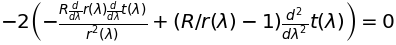

In [43]:
eqns[0]

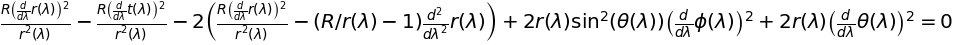

In [44]:
eqns[1]

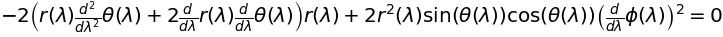

In [45]:
eqns[2]

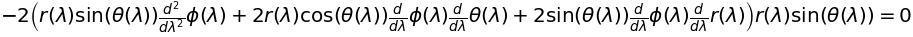

In [46]:
eqns[3]

In [47]:
from sympy.physics.mechanics import *
from sympy import diff, Symbol
t, r, theta, phi = dynamicsymbols('tau r theta phi')
dt, dr , dtheta, dphi = dynamicsymbols('tau r theta phi', 1)
kerr_metric.symbols()


## Second Method for the Schwarzschild Lagrangian
The `dynamicsymbols` function with '1' as second parameter assumes differentation w.r.t t, so note that here we have a $\tau$ where we usually have t, as well as a t where we usually have $\lambda$

In [48]:
from sympy.physics.mechanics import *
tau, r, theta, phi = dynamicsymbols('tau r theta phi')
dtau, dr, dtheta, dphi = dynamicsymbols('tau r theta phi', 1)

In [49]:
L = -(1-(R_sym/r))*dtau**2 + (1-(R_sym/r))**-1 * dr**2 + r**2 *dtheta**2 + r**2*sin(theta)**2*dphi**2
display(Math('L = ' + latex(L)))

<IPython.core.display.Math object>

In [50]:
LM = LagrangesMethod(L, [tau, r, theta, phi])
LM.form_lagranges_equations()

⎡                                        d        d                           
⎢                                    2⋅R⋅──(r(t))⋅──(τ(t))                2   
⎢                                        dt       dt         ⎛2⋅R     ⎞  d    
⎢                                  - ───────────────────── + ⎜──── - 2⎟⋅───(τ(
⎢                                             2              ⎝r(t)    ⎠   2   
⎢                                            r (t)                      dt    
⎢                                                                             
⎢                                                                             
⎢                  2                  2                                       
⎢        ⎛d       ⎞         ⎛d       ⎞                                        
⎢      R⋅⎜──(τ(t))⎟       R⋅⎜──(r(t))⎟                                   2    
⎢        ⎝dt      ⎠         ⎝dt      ⎠                 2       ⎛d       ⎞     
⎢      ───────────── - ─────────────────── - 2⋅r(t)⋅

Above we have the geodesic equations for the Schwarzchild metric